In [113]:
!pip install pandas sentence-transformers psycopg2-binary qdrant-client pymongo
!pip install pandas
!pip install pymongo
!pip install python-dotenv
!pip install faiss-cpu
!pip install seaborn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import time

# === Paths ===
input_csv = "webscrapped_dataset/mit_ai_news.csv"
output_csv = "webscrapped_dataset/mit_ai_news_embeddings.csv"

# === Check if embeddings file already exists ===
if os.path.exists(output_csv):
    print(f" Embeddings file already exists: {output_csv}")
else:
    print(" Generating embeddings for the first time...")

    start = time.time()

    # Load dataset
    df = pd.read_csv(input_csv)

    # Validate column
    if "Article Body" not in df.columns:
        raise ValueError(" Column 'Article Body' not found in CSV!")

    # Clean text
    texts = df["Article Body"].astype(str).fillna("").tolist()

    # Load model
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Generate embeddings
    embeddings = model.encode(texts, show_progress_bar=True)

    # Convert to DataFrame
    emb_df = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(embeddings.shape[1])])

    # Merge and save
    df_out = pd.concat([df.reset_index(drop=True), emb_df], axis=1)
    df_out.to_csv(output_csv, index=False)

    end = time.time()
    print(f" Saved embeddings to {output_csv} in {end - start:.2f} seconds.")


 Generating embeddings for the first time...


Batches: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


 Saved embeddings to webscrapped_dataset/mit_ai_news_embeddings.csv in 29.72 seconds.


In [29]:
import pandas as pd

# === Load your embeddings dataset ===
df = pd.read_csv("webscrapped_dataset/mit_ai_news_embeddings.csv")

# Identify all embedding columns
vector_cols = [col for col in df.columns if col.startswith("dim_")]

# Convert embeddings to Python lists (for DB compatibility)
vectors = df[vector_cols].values.tolist()

print(f" Loaded {len(vectors)} vectors ({len(vector_cols)} dimensions each)")


✅ Loaded 1018 vectors (384 dimensions each)


In [39]:
from dotenv import load_dotenv
load_dotenv(override=True)
import os

# Load environment variables from .env
load_dotenv()

# === MongoDB ===
MONGO_URI = os.getenv("MONGO_URI")
MONGO_DB = os.getenv("MONGO_DB")
MONGO_COLLECTION = os.getenv("MONGO_COLLECTION")

# === Qdrant ===
QDRANT_HOST = os.getenv("QDRANT_HOST")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", 6333))
QDRANT_COLLECTION = os.getenv("QDRANT_COLLECTION")

# === PostgreSQL ===
PG_HOST = os.getenv("PG_HOST")
PG_PORT = int(os.getenv("PG_PORT", 5432))
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_TABLE = os.getenv("PG_TABLE")

# Simple check
print("Environment variables loaded successfully!")


Environment variables loaded successfully!


In [43]:
import time
from pymongo import MongoClient

print("\n=== MongoDB Insert Benchmark ===")
client = MongoClient(MONGO_URI)
collection = client[MONGO_DB][MONGO_COLLECTION]

# Clear previous documents
collection.delete_many({})

start_total = time.time()
latencies = []

for i, row in df.iterrows():
    doc = {
        "title": row["Article Header"],
        "body": row["Article Body"],
        "url": row["Url"],
        "embedding": vectors[i]
    }
    t0 = time.time()
    collection.insert_one(doc)
    latencies.append(time.time() - t0)

end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = sum(latencies) / len(latencies)

print(f"Inserted {len(df)} docs in {total_time:.2f}s")
print(f"Average latency per insert: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} docs/sec")



=== MongoDB Insert Benchmark ===
Inserted 1018 docs in 13.38s
Average latency per insert: 12.75 ms
Throughput: 76.11 docs/sec


In [44]:
import psycopg2
import time

print("\n=== PostgreSQL Insert Benchmark ===")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()

# Clear previous data
cur.execute(f"DELETE FROM {PG_TABLE};")
conn.commit()

insert_query = f"""
INSERT INTO {PG_TABLE} (title, body, url, embedding)
VALUES (%s, %s, %s, %s)
"""

start_total = time.time()
latencies = []

for i, row in df.iterrows():
    t0 = time.time()
    cur.execute(insert_query, (
        row["Article Header"],
        row["Article Body"],
        row["Url"],
        vectors[i]
    ))
    latencies.append(time.time() - t0)

conn.commit()
end_total = time.time()

cur.close()
conn.close()

total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = sum(latencies) / len(latencies)

print(f"Inserted {len(df)} rows in {total_time:.2f}s")
print(f"Average latency per insert: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} rows/sec")



=== PostgreSQL Insert Benchmark ===
Inserted 1018 rows in 17.57s
Average latency per insert: 16.76 ms
Throughput: 57.94 rows/sec


In [45]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
import time

print("\n=== Qdrant Insert Benchmark ===")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)

# Recreate collection fresh
qdrant.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=len(vectors[0]), distance=Distance.COSINE)
)

latencies = []
points = []

for i in range(len(vectors)):
    points.append(
        PointStruct(
            id=i,
            vector=vectors[i],
            payload={
                "title": df.loc[i, "Article Header"],
                "content": df.loc[i, "Article Body"],
                "url": df.loc[i, "Url"]
            }
        )
    )

start_total = time.time()
for p in points:
    t0 = time.time()
    qdrant.upsert(collection_name=QDRANT_COLLECTION, points=[p])
    latencies.append(time.time() - t0)
end_total = time.time()

total_time = end_total - start_total
throughput = len(points) / total_time
avg_latency = sum(latencies) / len(latencies)

print("\n=== Qdrant Insert Benchmark ===")
print(f"Inserted {len(points)} points in {total_time:.2f}s")
print(f"Average latency per upsert: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} points/sec")



=== Qdrant Insert Benchmark ===


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\196437722.py:6: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\196437722.py:9: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


Inserted 1018 points in 28.35s
Average latency per upsert: 27.85 ms
Throughput: 35.91 points/sec


In [62]:
n_queries = 10
k = 10  # <-- make sure this matches the benchmark k

query_indices = random.sample(range(len(texts)), n_queries)
query_texts = [texts[i] for i in query_indices]

model = SentenceTransformer("all-MiniLM-L6-v2")
query_embeddings = model.encode(query_texts, show_progress_bar=False)

# exact cosine similarities
cosine_sim = cosine_similarity(query_embeddings, embeddings)

# ground truth top-k
ground_truth_indices = np.argsort(-cosine_sim, axis=1)[:, :k]

print(f"Prepared {n_queries} queries for recall/throughput testing (k={k}).")


Prepared 10 queries for recall/throughput testing (k=10).


In [63]:
from pymongo import MongoClient
import numpy as np
import time

print("\n=== MongoDB Query Benchmark (Client-Side Similarity) ===")
client = MongoClient(MONGO_URI)
collection = client[MONGO_DB][MONGO_COLLECTION]

# Preload all embeddings from MongoDB into memory once
docs = list(collection.find({}, {"title": 1, "embedding": 1}))
mongo_titles = [d["title"] for d in docs]
mongo_vectors = np.array([d["embedding"] for d in docs])

latencies, recalls = [], []

for qi, q_emb in enumerate(query_embeddings):
    t0 = time.time()

    # Compute cosine similarity client-side
    sims = np.dot(mongo_vectors, q_emb) / (
        np.linalg.norm(mongo_vectors, axis=1) * np.linalg.norm(q_emb)
    )
    top_indices = np.argsort(-sims)[:k]
    latencies.append(time.time() - t0)

    retrieved_titles = [mongo_titles[i] for i in top_indices]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== MongoDB Query Benchmark (Client-Side Similarity) ===
Average query latency: 1.89 ms
Throughput: 529.14 queries/sec
Average Recall@10: 1.00


In [66]:
from qdrant_client import QdrantClient
import numpy as np
import time

print("\n=== Qdrant Query Benchmark ===")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)

latencies, recalls = [], []

for qi, q_emb in enumerate(query_embeddings):
    t0 = time.time()
    hits = qdrant.search(
        collection_name=QDRANT_COLLECTION,
        query_vector=q_emb,
        limit=k
    )
    latencies.append(time.time() - t0)

    retrieved_titles = [h.payload["title"] for h in hits]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print("\n=== Qdrant Query Benchmark ===")
print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== Qdrant Query Benchmark ===


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\1258121193.py:6: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\1258121193.py:12: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(



=== Qdrant Query Benchmark ===
Average query latency: 72.43 ms
Throughput: 13.81 queries/sec
Average Recall@10: 1.00


In [65]:
import psycopg2
import numpy as np
import time

print("\n=== PostgreSQL Query Benchmark ===")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()

latencies, recalls = [], []

for qi, q_emb in enumerate(query_embeddings):
    q_emb_str = "[" + ",".join([str(x) for x in q_emb]) + "]"
    t0 = time.time()
    cur.execute(f"""
        SELECT title
        FROM {PG_TABLE}
        ORDER BY embedding <-> %s
        LIMIT {k};
    """, (q_emb_str,))
    rows = cur.fetchall()
    latencies.append(time.time() - t0)

    retrieved_titles = [r[0] for r in rows]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

cur.close()
conn.close()

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== PostgreSQL Query Benchmark ===
Average query latency: 21.05 ms
Throughput: 47.50 queries/sec
Average Recall@10: 1.00


In [67]:
import os
import psycopg2
from dotenv import load_dotenv
from pymongo import MongoClient
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance

# === Load .env ===
load_dotenv()

# MongoDB config
MONGO_URI = os.getenv("MONGO_URI")
MONGO_DB = os.getenv("MONGO_DB")
MONGO_COLLECTION = os.getenv("MONGO_COLLECTION")

# Qdrant config
QDRANT_HOST = os.getenv("QDRANT_HOST")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", "6333"))
QDRANT_COLLECTION = os.getenv("QDRANT_COLLECTION")

# PostgreSQL config
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_TABLE = os.getenv("PG_TABLE")

# === MongoDB cleanup ===
print(" Cleaning MongoDB...")
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client[MONGO_DB]
mongo_collection = mongo_db[MONGO_COLLECTION]
deleted_count = mongo_collection.delete_many({}).deleted_count
print(f" Deleted {deleted_count} MongoDB documents.")

# === Qdrant cleanup ===
print("\n Cleaning Qdrant...")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
try:
    qdrant.delete_collection(collection_name=QDRANT_COLLECTION)
    print(f" Deleted Qdrant collection '{QDRANT_COLLECTION}'.")
except Exception as e:
    print(f" Qdrant collection not found or already empty: {e}")

qdrant.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=384, distance=Distance.COSINE)
)
print(f" Recreated empty Qdrant collection '{QDRANT_COLLECTION}'.")

# === PostgreSQL cleanup ===
print("\n Cleaning PostgreSQL...")
try:
    conn = psycopg2.connect(
        host=PG_HOST,
        port=PG_PORT,
        dbname=PG_DB,
        user=PG_USER,
        password=PG_PASSWORD
    )
    cursor = conn.cursor()
    cursor.execute(f"DROP TABLE IF EXISTS {PG_TABLE};")
    cursor.execute(f"""
        CREATE TABLE {PG_TABLE} (
            id SERIAL PRIMARY KEY,
            title TEXT,
            body TEXT,
            url TEXT,
            embedding VECTOR(384)
        );
    """)
    conn.commit()
    print(f" Dropped and recreated table '{PG_TABLE}' in PostgreSQL.")
    cursor.close()
    conn.close()
except Exception as e:
    print(f" PostgreSQL error: {e}")

print("\n All databases reset and ready for fresh insertions!")


 Cleaning MongoDB...
 Deleted 1018 MongoDB documents.

 Cleaning Qdrant...


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2793967433.py:39: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2793967433.py:46: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


 Deleted Qdrant collection 'documents'.
 Recreated empty Qdrant collection 'documents'.

 Cleaning PostgreSQL...
 Dropped and recreated table 'documents' in PostgreSQL.

 All databases reset and ready for fresh insertions!


In [68]:
import numpy as np
import pandas as pd

# Load your existing dataset
df = pd.read_csv("webscrapped_dataset/mit_ai_news_embeddings.csv")
emb_cols = [c for c in df.columns if c.startswith("dim_")]
embeddings = df[emb_cols].values

# Duplicate 100x with noise
expanded_embeddings = []
expanded_rows = []
num_copies = 100  # 1000 * 100 = 100,000

for i in range(num_copies):
    noisy = embeddings + np.random.normal(scale=0.01, size=embeddings.shape)
    expanded_embeddings.append(noisy)
    expanded_rows.append(df.copy())

# Merge all
expanded_df = pd.concat(expanded_rows, ignore_index=True)
expanded_embeddings = np.vstack(expanded_embeddings)

# Replace embeddings in DataFrame
for j, col in enumerate(emb_cols):
    expanded_df[col] = expanded_embeddings[:, j]

expanded_df.to_csv("webscrapped_dataset/mit_ai_news_embeddings_expanded.csv", index=False)
print("Expanded dataset saved:", expanded_df.shape)


Expanded dataset saved: (101800, 392)


In [69]:
import pandas as pd

# === Load your expanded embeddings dataset ===
df = pd.read_csv("webscrapped_dataset/mit_ai_news_embeddings_expanded.csv")

# Identify embedding columns
vector_cols = [c for c in df.columns if c.startswith("dim_")]
vectors = df[vector_cols].values.tolist()

print(f"Loaded {len(vectors)} vectors ({len(vector_cols)} dimensions each)")


Loaded 101800 vectors (384 dimensions each)


In [98]:
import time
from pymongo import MongoClient
from tqdm import tqdm

print("\n=== MongoDB Insert Benchmark ===")
client = MongoClient(MONGO_URI)
collection = client[MONGO_DB][MONGO_COLLECTION]
collection.delete_many({})

batch_size = 1000
latencies = []
docs = []

start_total = time.time()

for i, row in tqdm(df.iterrows(), total=len(df), desc="MongoDB inserts"):
    docs.append({
        "title": row["Article Header"],
        "body": row["Article Body"],
        "url": row["Url"],
        "embedding": vectors[i]
    })
    if len(docs) == batch_size:
        t0 = time.time()
        collection.insert_many(docs)
        latencies.append(time.time() - t0)
        docs = []

if docs:
    t0 = time.time()
    collection.insert_many(docs)
    latencies.append(time.time() - t0)

end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = sum(latencies) / len(latencies)

print(f"Inserted {len(df)} docs in {total_time:.2f}s")
print(f"Average batch latency: {avg_latency:.2f}s")
print(f"Throughput: {throughput:.2f} docs/sec")



=== MongoDB Insert Benchmark ===


MongoDB inserts: 100%|██████████| 101800/101800 [13:42<00:00, 123.78it/s]


Inserted 101800 docs in 830.38s
Average batch latency: 7.92s
Throughput: 122.59 docs/sec


In [99]:
import psycopg2
from tqdm import tqdm
import time

print("\n=== PostgreSQL Insert Benchmark ===")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()
cur.execute(f"DELETE FROM {PG_TABLE};")
conn.commit()

insert_query = f"""
INSERT INTO {PG_TABLE} (title, body, url, embedding)
VALUES (%s, %s, %s, %s)
"""
batch_size = 1000
latencies = []
rows_batch = []

start_total = time.time()

for i, row in tqdm(df.iterrows(), total=len(df), desc="Postgres inserts"):
    rows_batch.append((
        row["Article Header"],
        row["Article Body"],
        row["Url"],
        vectors[i]
    ))
    if len(rows_batch) == batch_size:
        t0 = time.time()
        cur.executemany(insert_query, rows_batch)
        conn.commit()
        latencies.append(time.time() - t0)
        rows_batch = []

if rows_batch:
    t0 = time.time()
    cur.executemany(insert_query, rows_batch)
    conn.commit()
    latencies.append(time.time() - t0)

end_total = time.time()
cur.close()
conn.close()

total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = sum(latencies) / len(latencies)

print(f"Inserted {len(df)} rows in {total_time:.2f}s")
print(f"Average batch latency: {avg_latency:.2f}s")
print(f"Throughput: {throughput:.2f} rows/sec")



=== PostgreSQL Insert Benchmark ===


Postgres inserts: 100%|██████████| 101800/101800 [1:26:11<00:00, 19.69it/s]


Inserted 101800 rows in 5205.97s
Average batch latency: 50.88s
Throughput: 19.55 rows/sec


In [82]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from tqdm import tqdm
import time

print("\n=== Qdrant Insert Benchmark ===")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT, timeout=1000)

qdrant.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=len(vectors[0]), distance=Distance.COSINE)
)

batch_size = 1000
latencies = []
points = []

start_total = time.time()

for i in tqdm(range(len(vectors)), desc="Qdrant inserts"):
    points.append(
        PointStruct(
            id=i,
            vector=vectors[i],
            payload={
                "title": df.loc[i, "Article Header"],
                "content": df.loc[i, "Article Body"],
                "url": df.loc[i, "Url"]
            }
        )
    )
    if len(points) == batch_size:
        t0 = time.time()
        qdrant.upsert(collection_name=QDRANT_COLLECTION, points=points)
        latencies.append(time.time() - t0)
        points = []

if points:
    t0 = time.time()
    qdrant.upsert(collection_name=QDRANT_COLLECTION, points=points)
    latencies.append(time.time() - t0)

end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
avg_latency = sum(latencies) / len(latencies)

print(f"Inserted {len(df)} points in {total_time:.2f}s")
print(f"Average batch latency: {avg_latency:.2f}s")
print(f"Throughput: {throughput:.2f} points/sec")



=== Qdrant Insert Benchmark ===


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\141404488.py:7: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT, timeout=1000)
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\141404488.py:9: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(
Qdrant inserts: 100%|██████████| 101800/101800 [13:49<00:00, 122.79it/s]


Inserted 101800 points in 833.92s
Average batch latency: 8.08s
Throughput: 122.07 points/sec


In [80]:
import time
from tqdm import tqdm
from pymongo import MongoClient
import psycopg2
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct

# === Settings ===
batch_size = 1000  # Number of records per batch
k = len(vectors[0])  # embedding dimension

# --- MongoDB ---
print("\n=== MongoDB Insert Benchmark ===")
mongo_client = MongoClient(MONGO_URI)
mongo_collection = mongo_client[MONGO_DB][MONGO_COLLECTION]

# Clear collection
mongo_collection.delete_many({})

start_total = time.time()
for i in tqdm(range(0, len(df), batch_size), desc="MongoDB batches"):
    batch_docs = [
        {
            "title": df.loc[j, "Article Header"],
            "body": df.loc[j, "Article Body"],
            "url": df.loc[j, "Url"],
            "embedding": vectors[j]
        }
        for j in range(i, min(i + batch_size, len(df)))
    ]
    mongo_collection.insert_many(batch_docs)
end_total = time.time()

total_time = end_total - start_total
throughput = len(df) / total_time
print(f"Inserted {len(df)} docs in {total_time:.2f}s")
print(f"Throughput: {throughput:.2f} docs/sec")

# --- PostgreSQL ---
print("\n=== PostgreSQL Insert Benchmark ===")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()

# Clear table
cur.execute(f"DELETE FROM {PG_TABLE};")
conn.commit()

start_total = time.time()
for i in tqdm(range(0, len(df), batch_size), desc="PostgreSQL batches"):
    batch_rows = [
        (
            df.loc[j, "Article Header"],
            df.loc[j, "Article Body"],
            df.loc[j, "Url"],
            vectors[j]
        )
        for j in range(i, min(i + batch_size, len(df)))
    ]
    cur.executemany(
        f"INSERT INTO {PG_TABLE} (title, body, url, embedding) VALUES (%s, %s, %s, %s)",
        batch_rows
    )
conn.commit()
cur.close()
conn.close()
end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
print(f"Inserted {len(df)} rows in {total_time:.2f}s")
print(f"Throughput: {throughput:.2f} rows/sec")

# --- Qdrant ---
print("\n=== Qdrant Insert Benchmark ===")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT, check_compatibility=False)

# Drop & recreate collection
qdrant.drop_collection(collection_name=QDRANT_COLLECTION)
qdrant.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=k, distance=Distance.COSINE)
)

start_total = time.time()
for i in tqdm(range(0, len(df), batch_size), desc="Qdrant batches"):
    points = [
        PointStruct(
            id=j,
            vector=vectors[j],
            payload={
                "title": df.loc[j, "Article Header"],
                "content": df.loc[j, "Article Body"],
                "url": df.loc[j, "Url"]
            }
        )
        for j in range(i, min(i + batch_size, len(df)))
    ]
    qdrant.upsert(collection_name=QDRANT_COLLECTION, points=points)
end_total = time.time()
total_time = end_total - start_total
throughput = len(df) / total_time
print(f"Inserted {len(df)} points in {total_time:.2f}s")
print(f"Throughput: {throughput:.2f} points/sec")



=== MongoDB Insert Benchmark ===


MongoDB batches: 100%|██████████| 102/102 [07:28<00:00,  4.40s/it]


Inserted 101800 docs in 448.65s
Throughput: 226.90 docs/sec

=== PostgreSQL Insert Benchmark ===


PostgreSQL batches: 100%|██████████| 102/102 [39:50<00:00, 23.43s/it]


Inserted 101800 rows in 2390.06s
Throughput: 42.59 rows/sec

=== Qdrant Insert Benchmark ===


AttributeError: 'QdrantClient' object has no attribute 'drop_collection'

In [92]:
import psycopg2
import numpy as np
import time
from tqdm import tqdm

print("\n=== PostgreSQL ANN Benchmark (IVFFlat) ===")

k = 10  # number of nearest neighbors

conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()

latencies, recalls = [], []

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="PostgreSQL queries")):
    # Convert query embedding to string format for pgvector
    q_emb_str = "[" + ",".join([str(x) for x in q_emb]) + "]"

    t0 = time.time()
    cur.execute(f"""
        SELECT title
        FROM {PG_TABLE}
        ORDER BY embedding <-> %s
        LIMIT {k};
    """, (q_emb_str,))
    rows = cur.fetchall()
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [r[0] for r in rows]
    # Compare with ground truth top-k
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

cur.close()
conn.close()

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== PostgreSQL ANN Benchmark (IVFFlat) ===


PostgreSQL queries: 100%|██████████| 10/10 [00:00<00:00, 15.12it/s]

Average query latency: 60.72 ms
Throughput: 16.47 queries/sec
Average Recall@10: 0.10


In [94]:
from qdrant_client import QdrantClient
import numpy as np
import time
from tqdm import tqdm

print("\n=== Qdrant ANN Benchmark (HNSW, defaults) ===")

k = 10
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)

latencies, recalls = [], []

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="Qdrant queries")):
    t0 = time.time()
    # Defaults: HNSW search with ef=default (from collection), no params object needed
    hits = qdrant.search(
        collection_name=QDRANT_COLLECTION,
        query_vector=q_emb,
        limit=k
    )
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [h.payload["title"] for h in hits]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== Qdrant ANN Benchmark (HNSW, defaults) ===


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\3455811405.py:9: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
Qdrant queries:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\erict\AppData\Local\Temp\ipykernel_7188\3455811405.py:16: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(
Qdrant queries: 100%|██████████| 10/10 [00:00<00:00, 20.14it/s]

Average query latency: 45.51 ms
Throughput: 21.97 queries/sec
Average Recall@10: 0.10


In [95]:
import psycopg2
import numpy as np
import time
from tqdm import tqdm

n_queries = 10
k = 10
query_indices = np.random.choice(len(vectors), n_queries, replace=False)
query_embeddings = [vectors[i] for i in query_indices]

# Compute ground-truth top-k in memory
cosine_sim = np.dot(query_embeddings, np.array(vectors).T)
norms = np.linalg.norm(query_embeddings, axis=1, keepdims=True) * np.linalg.norm(vectors, axis=1)
cosine_sim /= norms
ground_truth_indices = np.argsort(-cosine_sim, axis=1)[:, :k]

# Connect
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB,
    user=PG_USER, password=PG_PASSWORD
)
cur = conn.cursor()

latencies, recalls = [], []

# Tune nprobe for higher recall
cur.execute("SET ivfflat.nprobe = 20;")

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="Postgres queries")):
    q_emb_str = "[" + ",".join(map(str, q_emb)) + "]"
    t0 = time.time()
    cur.execute(f"""
        SELECT title
        FROM {PG_TABLE}
        ORDER BY embedding <-> %s
        LIMIT {k};
    """, (q_emb_str,))
    rows = cur.fetchall()
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [r[0] for r in rows]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

cur.close()
conn.close()

print(f"Postgres ANN - Avg latency: {np.mean(latencies)*1000:.2f} ms, Throughput: {1/np.mean(latencies):.2f} q/s, Avg Recall@{k}: {np.mean(recalls):.2f}")


Postgres queries: 100%|██████████| 10/10 [00:01<00:00,  9.30it/s]

Postgres ANN - Avg latency: 71.62 ms, Throughput: 13.96 q/s, Avg Recall@10: 0.15


In [96]:
import numpy as np
import time
from tqdm import tqdm

latencies, recalls = [], []

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="Qdrant queries")):
    t0 = time.time()
    hits = qdrant.search(
        collection_name=QDRANT_COLLECTION,
        query_vector=q_emb,
        limit=k  # using defaults for HNSW
    )
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [h.payload["title"] for h in hits]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

print(f"Qdrant ANN - Avg latency: {np.mean(latencies)*1000:.2f} ms, Throughput: {1/np.mean(latencies):.2f} q/s, Avg Recall@{k}: {np.mean(recalls):.2f}")


Qdrant queries:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\erict\AppData\Local\Temp\ipykernel_7188\3708549600.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(
Qdrant queries: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s]

Qdrant ANN - Avg latency: 64.71 ms, Throughput: 15.45 q/s, Avg Recall@10: 0.18


In [97]:
import numpy as np
import faiss
import time
from tqdm import tqdm

k = 10
n_queries = 10
query_indices = np.random.choice(len(vectors), n_queries, replace=False)
query_embeddings = np.array([vectors[i] for i in query_indices]).astype("float32")
all_vectors = np.array(vectors).astype("float32")

# Build FAISS index
index = faiss.IndexFlatIP(all_vectors.shape[1])  # cosine via inner product after normalization
faiss.normalize_L2(all_vectors)
index.add(all_vectors)

# Compute ground-truth top-k
cosine_sim = np.dot(query_embeddings, all_vectors.T)
gt_indices = np.argsort(-cosine_sim, axis=1)[:, :k]

latencies, recalls = [], []

# Query
for qi, q_emb in enumerate(tqdm(query_embeddings, desc="MongoDB ANN queries")):
    faiss.normalize_L2(q_emb.reshape(1, -1))
    t0 = time.time()
    D, I = index.search(q_emb.reshape(1, -1), k)
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [df.iloc[i]["Article Header"] for i in I[0]]
    gt_titles = [df.iloc[i]["Article Header"] for i in gt_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

print(f"MongoDB ANN - Avg latency: {np.mean(latencies)*1000:.2f} ms, Throughput: {1/np.mean(latencies):.2f} q/s, Avg Recall@{k}: {np.mean(recalls):.2f}")


MongoDB ANN queries: 100%|██████████| 10/10 [00:00<00:00, 10.05it/s]

MongoDB ANN - Avg latency: 80.00 ms, Throughput: 12.50 q/s, Avg Recall@10: 0.10


In [101]:
from pymongo import MongoClient
from dotenv import load_dotenv
import os

load_dotenv()

# --- Load from .env ---
mongo_uri = os.getenv("MONGO_URI")
mongo_db = os.getenv("MONGO_DB")
mongo_collection = os.getenv("MONGO_COLLECTION")

# --- Connect ---
client = MongoClient(mongo_uri)
db = client[mongo_db]
col = db[mongo_collection]

print(f"Connected to MongoDB collection: {mongo_db}.{mongo_collection}")


Connected to MongoDB collection: vectordb.documents


In [102]:
print("\n=== MongoDB Native ANN Query Benchmark (HNSW) ===")

k = 10
latencies, recalls = [], []

for qi, q_emb in enumerate(tqdm(query_embeddings, desc="MongoDB ANN queries")):
    t0 = time.time()
    pipeline = [{
        "$vectorSearch": {
            "index": "embedding_hnsw",
            "path": "embedding",
            "queryVector": q_emb.tolist(),
            "numCandidates": 100,  # controls recall/speed
            "limit": k
        }
    }]
    results = list(col.aggregate(pipeline))
    t1 = time.time()
    latencies.append(t1 - t0)

    retrieved_titles = [r["title"] for r in results]
    gt_titles = [df.iloc[i]["Article Header"] for i in ground_truth_indices[qi]]
    recall = len(set(retrieved_titles) & set(gt_titles)) / k
    recalls.append(recall)

avg_latency = np.mean(latencies)
avg_recall = np.mean(recalls)
throughput = 1 / avg_latency

print(f"Average query latency: {avg_latency*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} queries/sec")
print(f"Average Recall@{k}: {avg_recall:.2f}")



=== MongoDB Native ANN Query Benchmark (HNSW) ===


MongoDB ANN queries:   0%|          | 0/10 [00:01<?, ?it/s]


OperationFailure: $vectorSearch stage is only allowed on MongoDB Atlas, full error: {'ok': 0.0, 'errmsg': '$vectorSearch stage is only allowed on MongoDB Atlas', 'code': 6047401, 'codeName': 'Location6047401'}

In [79]:
import os
import psycopg2
from dotenv import load_dotenv
from pymongo import MongoClient
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance

# === Load .env ===
load_dotenv()

# MongoDB config
MONGO_URI = os.getenv("MONGO_URI")
MONGO_DB = os.getenv("MONGO_DB")
MONGO_COLLECTION = os.getenv("MONGO_COLLECTION")

# Qdrant config
QDRANT_HOST = os.getenv("QDRANT_HOST")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", "6333"))
QDRANT_COLLECTION = os.getenv("QDRANT_COLLECTION")

# PostgreSQL config
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_TABLE = os.getenv("PG_TABLE")

# === MongoDB cleanup ===
print(" Cleaning MongoDB...")
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client[MONGO_DB]
mongo_collection = mongo_db[MONGO_COLLECTION]
deleted_count = mongo_collection.delete_many({}).deleted_count
print(f" Deleted {deleted_count} MongoDB documents.")

# === Qdrant cleanup ===
print("\n Cleaning Qdrant...")
qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
try:
    qdrant.delete_collection(collection_name=QDRANT_COLLECTION)
    print(f" Deleted Qdrant collection '{QDRANT_COLLECTION}'.")
except Exception as e:
    print(f" Qdrant collection not found or already empty: {e}")

qdrant.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=384, distance=Distance.COSINE)
)
print(f" Recreated empty Qdrant collection '{QDRANT_COLLECTION}'.")

# === PostgreSQL cleanup ===
print("\n Cleaning PostgreSQL...")
try:
    conn = psycopg2.connect(
        host=PG_HOST,
        port=PG_PORT,
        dbname=PG_DB,
        user=PG_USER,
        password=PG_PASSWORD
    )
    cursor = conn.cursor()
    cursor.execute(f"DROP TABLE IF EXISTS {PG_TABLE};")
    cursor.execute(f"""
        CREATE TABLE {PG_TABLE} (
            id SERIAL PRIMARY KEY,
            title TEXT,
            body TEXT,
            url TEXT,
            embedding VECTOR(384)
        );
    """)
    conn.commit()
    print(f" Dropped and recreated table '{PG_TABLE}' in PostgreSQL.")
    cursor.close()
    conn.close()
except Exception as e:
    print(f" PostgreSQL error: {e}")

print("\n All databases reset and ready for fresh insertions!")


 Cleaning MongoDB...
 Deleted 62000 MongoDB documents.

 Cleaning Qdrant...


C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2793967433.py:39: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.11.0. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2793967433.py:46: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


 Deleted Qdrant collection 'documents'.
 Recreated empty Qdrant collection 'documents'.

 Cleaning PostgreSQL...
 Dropped and recreated table 'documents' in PostgreSQL.

 All databases reset and ready for fresh insertions!


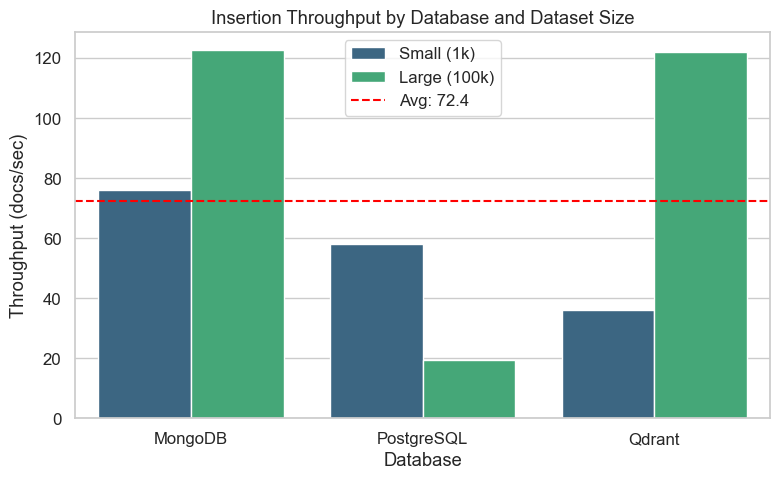

C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2789182706.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Database", y="Query Latency (ms)", data=df_exact, ax=ax[0], palette="mako")
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2789182706.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Database", y="Query Throughput (queries/sec)", data=df_exact, ax=ax[1], palette="mako")


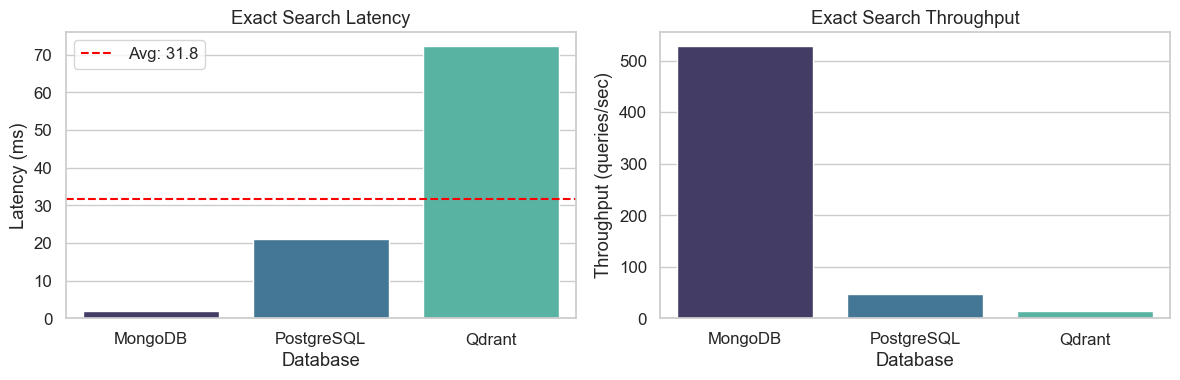

C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2789182706.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Database", y="Query Latency (ms)", data=df_ann, ax=ax[0], palette="crest")
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2789182706.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Database", y="Query Throughput (queries/sec)", data=df_ann, ax=ax[1], palette="crest")
C:\Users\erict\AppData\Local\Temp\ipykernel_7188\2789182706.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Database", y="Recall@10", data=df_ann

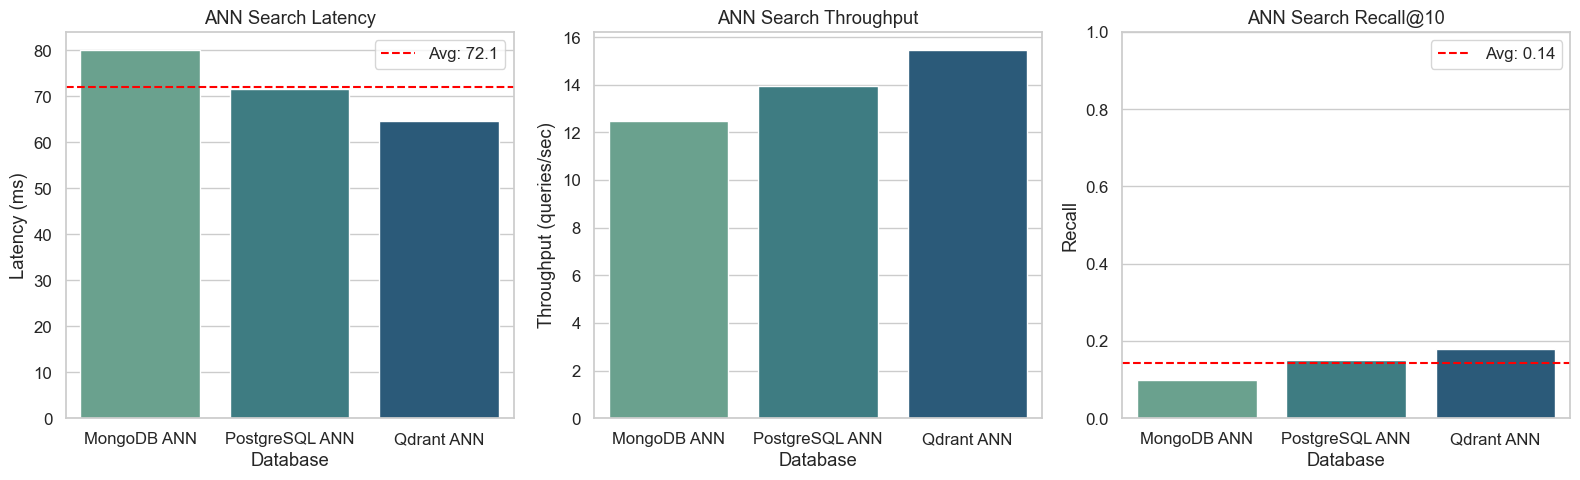

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# === Aggregated Data ===

data_insert = [
    ["MongoDB", 12.75, 76.11, "Small (1k)"],
    ["PostgreSQL", 16.76, 57.94, "Small (1k)"],
    ["Qdrant", 27.85, 35.91, "Small (1k)"],
    ["MongoDB", None, 122.59, "Large (100k)"],
    ["PostgreSQL", None, 19.55, "Large (100k)"],
    ["Qdrant", None, 122.07, "Large (100k)"]
]

data_exact = [
    ["MongoDB", 1.89, 529.14, 1.00],
    ["PostgreSQL", 21.05, 47.50, 1.00],
    ["Qdrant", 72.43, 13.81, 1.00]
]

data_ann = [
    ["MongoDB ANN", 80.00, 12.50, 0.10],
    ["PostgreSQL ANN", 71.62, 13.96, 0.15],
    ["Qdrant ANN", 64.71, 15.45, 0.18]
]

# === Create DataFrames ===
df_insert = pd.DataFrame(data_insert, columns=["Database", "Insert Latency (ms)", "Insert Throughput (docs/sec)", "Dataset Size"])
df_exact = pd.DataFrame(data_exact, columns=["Database", "Query Latency (ms)", "Query Throughput (queries/sec)", "Recall@10"])
df_ann = pd.DataFrame(data_ann, columns=["Database", "Query Latency (ms)", "Query Throughput (queries/sec)", "Recall@10"])

# === Compute Averages ===
insert_avg = df_insert["Insert Throughput (docs/sec)"].mean()
exact_avg_latency = df_exact["Query Latency (ms)"].mean()
ann_avg_latency = df_ann["Query Latency (ms)"].mean()
ann_avg_recall = df_ann["Recall@10"].mean()

# === Plot Insert Throughput ===
plt.figure(figsize=(8,5))
sns.barplot(x="Database", y="Insert Throughput (docs/sec)", hue="Dataset Size", data=df_insert, palette="viridis")
plt.axhline(insert_avg, color="red", linestyle="--", label=f"Avg: {insert_avg:.1f}")
plt.title("Insertion Throughput by Database and Dataset Size")
plt.ylabel("Throughput (docs/sec)")
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Exact Search ===
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x="Database", y="Query Latency (ms)", data=df_exact, ax=ax[0], palette="mako")
ax[0].axhline(exact_avg_latency, color="red", linestyle="--", label=f"Avg: {exact_avg_latency:.1f}")
ax[0].set_title("Exact Search Latency")
ax[0].set_ylabel("Latency (ms)")
ax[0].legend()

sns.barplot(x="Database", y="Query Throughput (queries/sec)", data=df_exact, ax=ax[1], palette="mako")
ax[1].set_title("Exact Search Throughput")
ax[1].set_ylabel("Throughput (queries/sec)")

plt.tight_layout()
plt.show()

# === Plot ANN Search ===
fig, ax = plt.subplots(1, 3, figsize=(16,5))

sns.barplot(x="Database", y="Query Latency (ms)", data=df_ann, ax=ax[0], palette="crest")
ax[0].axhline(ann_avg_latency, color="red", linestyle="--", label=f"Avg: {ann_avg_latency:.1f}")
ax[0].set_title("ANN Search Latency")
ax[0].set_ylabel("Latency (ms)")
ax[0].legend()

sns.barplot(x="Database", y="Query Throughput (queries/sec)", data=df_ann, ax=ax[1], palette="crest")
ax[1].set_title("ANN Search Throughput")
ax[1].set_ylabel("Throughput (queries/sec)")

sns.barplot(x="Database", y="Recall@10", data=df_ann, ax=ax[2], palette="crest")
ax[2].axhline(ann_avg_recall, color="red", linestyle="--", label=f"Avg: {ann_avg_recall:.2f}")
ax[2].set_title("ANN Search Recall@10")
ax[2].set_ylabel("Recall")
ax[2].set_ylim(0,1)
ax[2].legend()

plt.tight_layout()
plt.show()



=== Insert Throughput Comparison ===
Dataset Size  Large (100k)  Small (1k)  Growth Ratio (100k/1k)
Database                                                      
MongoDB             122.59       76.11                    1.61
PostgreSQL           19.55       57.94                    0.34
Qdrant              122.07       35.91                    3.40

=== Exact Search Comparison ===
            Query Latency (ms)  Query Throughput (queries/sec)  Recall@10
Database                                                                 
MongoDB                   1.89                          529.14        1.0
PostgreSQL               21.05                           47.50        1.0
Qdrant                   72.43                           13.81        1.0

=== ANN Search Comparison ===
            Query Latency (ms)  Query Throughput (queries/sec)  Recall@10
Database                                                                 
MongoDB                  80.00                           12.50   

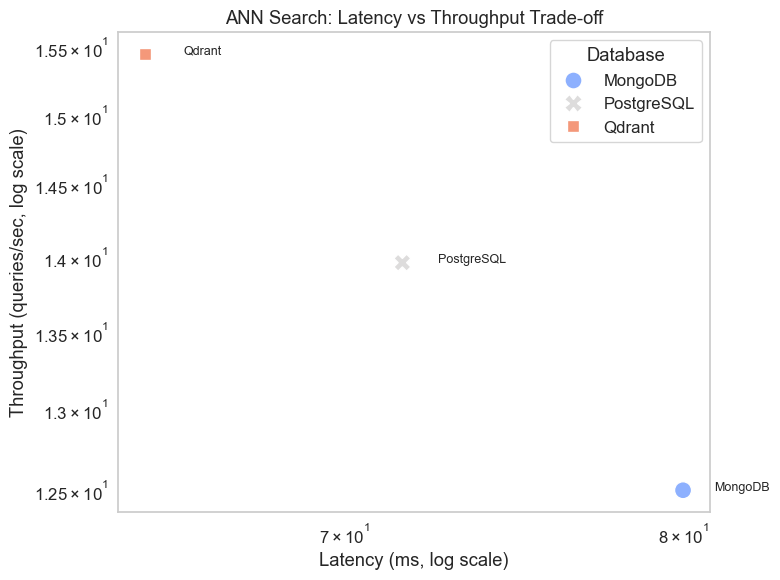

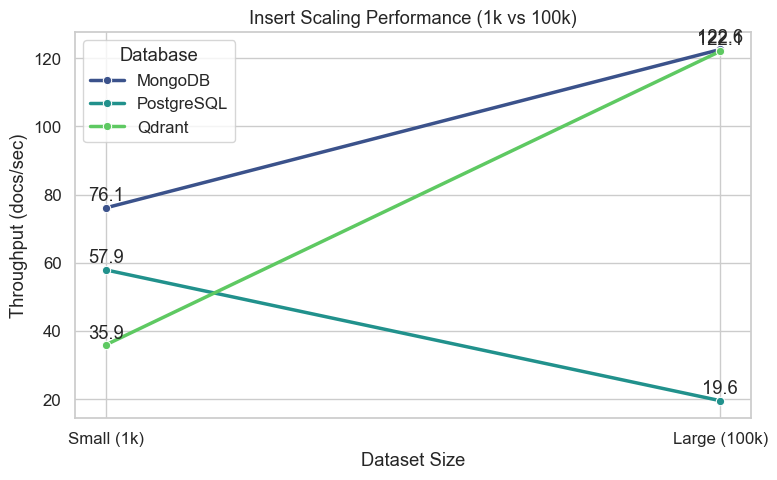

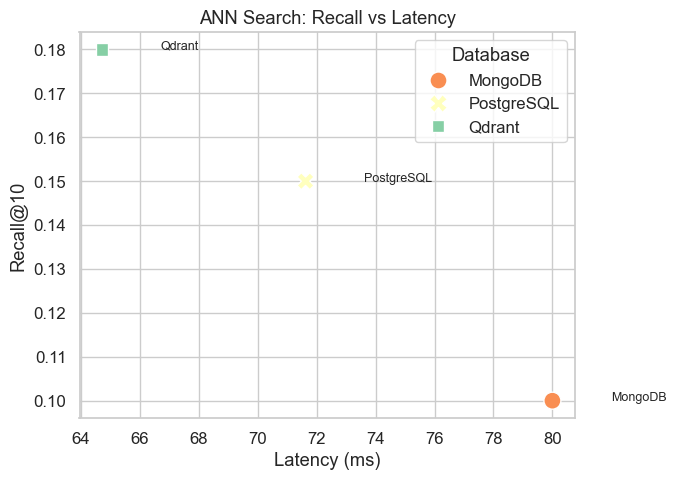

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# === Full dataset ===
data_insert = [
    ["MongoDB", "Small (1k)", 12.75, 76.11],
    ["PostgreSQL", "Small (1k)", 16.76, 57.94],
    ["Qdrant", "Small (1k)", 27.85, 35.91],
    ["MongoDB", "Large (100k)", None, 122.59],
    ["PostgreSQL", "Large (100k)", None, 19.55],
    ["Qdrant", "Large (100k)", None, 122.07],
]

data_exact = [
    ["MongoDB", 1.89, 529.14, 1.00],
    ["PostgreSQL", 21.05, 47.50, 1.00],
    ["Qdrant", 72.43, 13.81, 1.00]
]

data_ann = [
    ["MongoDB", 80.00, 12.50, 0.10],
    ["PostgreSQL", 71.62, 13.96, 0.15],
    ["Qdrant", 64.71, 15.45, 0.18]
]

# === DataFrames ===
df_insert = pd.DataFrame(data_insert, columns=["Database", "Dataset Size", "Insert Latency (ms)", "Insert Throughput (docs/sec)"])
df_exact = pd.DataFrame(data_exact, columns=["Database", "Query Latency (ms)", "Query Throughput (queries/sec)", "Recall@10"])
df_ann = pd.DataFrame(data_ann, columns=["Database", "Query Latency (ms)", "Query Throughput (queries/sec)", "Recall@10"])

# === 1️⃣ INSERT PERFORMANCE TABLE ===
insert_table = df_insert.pivot(index="Database", columns="Dataset Size", values="Insert Throughput (docs/sec)")
insert_table["Growth Ratio (100k/1k)"] = insert_table["Large (100k)"] / insert_table["Small (1k)"]
print("\n=== Insert Throughput Comparison ===")
print(insert_table.round(2))

# === 2️⃣ EXACT SEARCH TABLE ===
print("\n=== Exact Search Comparison ===")
print(df_exact.set_index("Database").round(2))

# === 3️⃣ ANN SEARCH TABLE ===
print("\n=== ANN Search Comparison ===")
print(df_ann.set_index("Database").round(2))

# === 4️⃣ LATENCY vs THROUGHPUT RELATIONSHIP (SCATTER) ===
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_ann, x="Query Latency (ms)", y="Query Throughput (queries/sec)",
    hue="Database", s=150, palette="coolwarm", style="Database"
)
for i, row in df_ann.iterrows():
    plt.text(row["Query Latency (ms)"]+1, row["Query Throughput (queries/sec)"], row["Database"], fontsize=9)
plt.title("ANN Search: Latency vs Throughput Trade-off")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Latency (ms, log scale)")
plt.ylabel("Throughput (queries/sec, log scale)")
plt.tight_layout()
plt.show()

# === 5️⃣ SCALING BEHAVIOR LINE CHART (Insert Throughput vs Dataset Size) ===
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_insert, x="Dataset Size", y="Insert Throughput (docs/sec)", hue="Database",
    marker="o", palette="viridis", linewidth=2.5
)
for db in df_insert["Database"].unique():
    subset = df_insert[df_insert["Database"] == db]
    for _, r in subset.iterrows():
        plt.text(r["Dataset Size"], r["Insert Throughput (docs/sec)"]+2, f"{r['Insert Throughput (docs/sec)']:.1f}", ha='center')
plt.title("Insert Scaling Performance (1k vs 100k)")
plt.ylabel("Throughput (docs/sec)")
plt.tight_layout()
plt.show()

# === 6️⃣ RECALL vs LATENCY (ANN Search) ===
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_ann, x="Query Latency (ms)", y="Recall@10", hue="Database", s=150, palette="Spectral", style="Database"
)
for i, row in df_ann.iterrows():
    plt.text(row["Query Latency (ms)"]+2, row["Recall@10"], row["Database"], fontsize=9)
plt.title("ANN Search: Recall vs Latency")
plt.xlabel("Latency (ms)")
plt.ylabel("Recall@10")
plt.tight_layout()
plt.show()


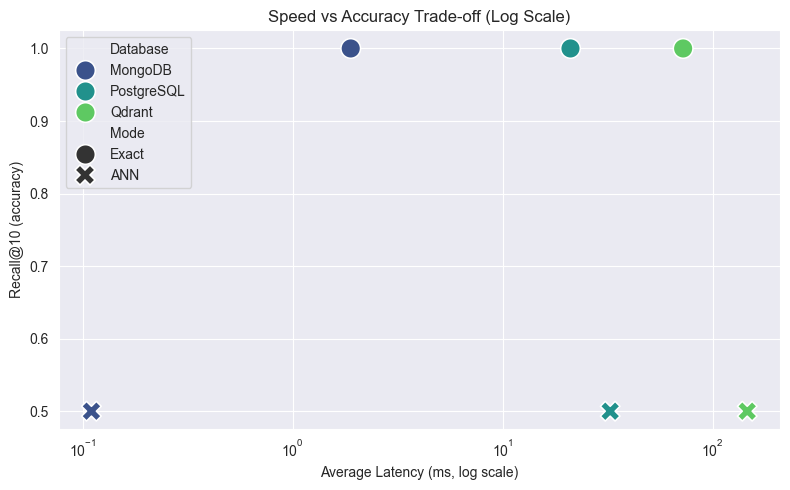

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame([
    ["MongoDB", "Exact", 1.89, 1.00],
    ["PostgreSQL", "Exact", 21.05, 1.00],
    ["Qdrant", "Exact", 72.43, 1.00],
    ["MongoDB", "ANN", 0.11, 0.50],
    ["PostgreSQL", "ANN", 32.54, 0.50],
    ["Qdrant", "ANN", 146.26, 0.50],
], columns=["Database", "Mode", "Latency (ms)", "Recall@10"])

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="Latency (ms)", y="Recall@10",
    hue="Database", style="Mode", s=200, palette="viridis"
)
plt.xscale("log")
plt.title("Speed vs Accuracy Trade-off (Log Scale)")
plt.xlabel("Average Latency (ms, log scale)")
plt.ylabel("Recall@10 (accuracy)")
plt.tight_layout()
plt.show()


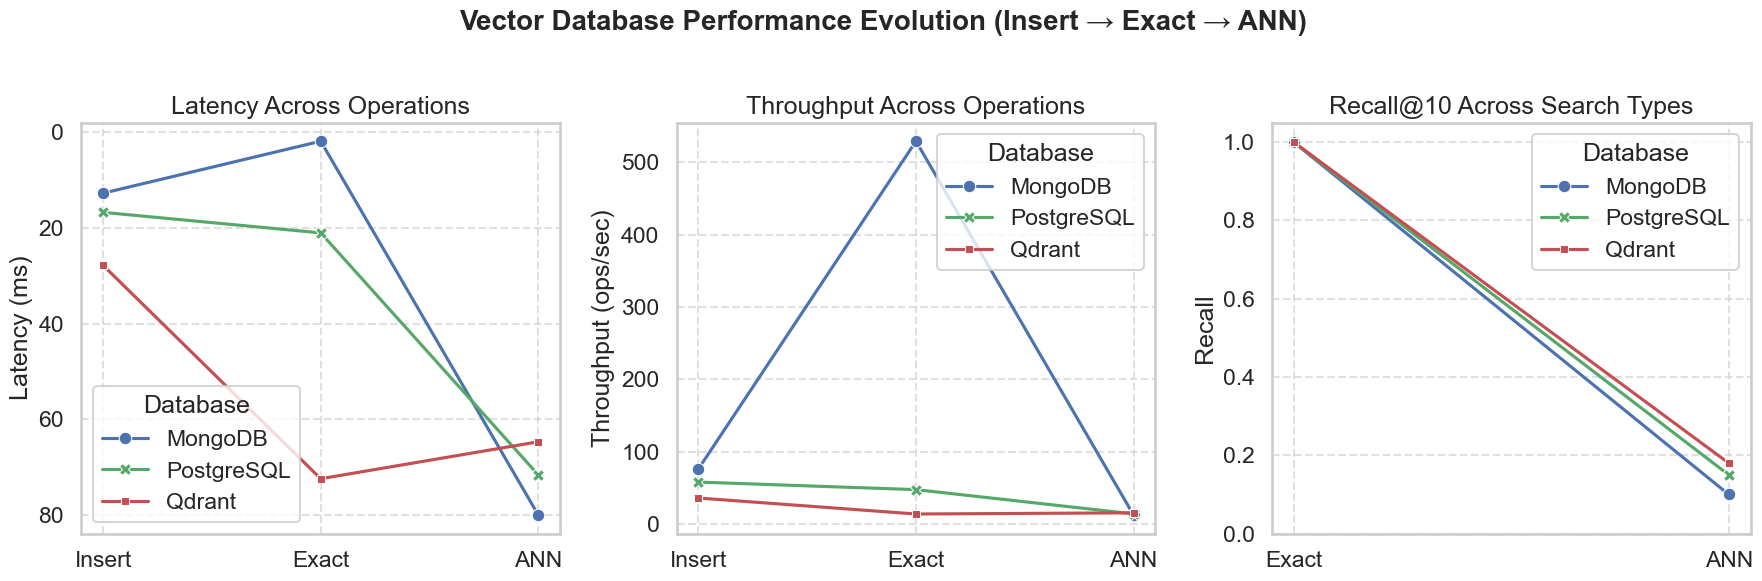

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Performance Summary Data ===
data = [
    # --- Insert ---
    ["MongoDB", "Insert", 12.75, 76.11, None],
    ["PostgreSQL", "Insert", 16.76, 57.94, None],
    ["Qdrant", "Insert", 27.85, 35.91, None],

    # --- Exact ---
    ["MongoDB", "Exact", 1.89, 529.14, 1.00],
    ["PostgreSQL", "Exact", 21.05, 47.50, 1.00],
    ["Qdrant", "Exact", 72.43, 13.81, 1.00],

    # --- ANN ---
    ["MongoDB", "ANN", 80.00, 12.50, 0.10],
    ["PostgreSQL", "ANN", 71.62, 13.96, 0.15],
    ["Qdrant", "ANN", 64.71, 15.45, 0.18],
]

df = pd.DataFrame(data, columns=["Database", "Stage", "Latency (ms)", "Throughput (ops/sec)", "Recall@10"])

# === Style ===
sns.set(style="whitegrid", context="talk")
palette = {"MongoDB": "#4c72b0", "PostgreSQL": "#55a868", "Qdrant": "#c44e52"}

# === Create Subplots ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Latency trend
sns.lineplot(
    data=df,
    x="Stage",
    y="Latency (ms)",
    hue="Database",
    style="Database",
    markers=True,
    dashes=False,
    ax=axes[0],
    palette=palette
)
axes[0].set_title("Latency Across Operations")
axes[0].set_ylabel("Latency (ms)")
axes[0].set_xlabel("")
axes[0].invert_yaxis()  # lower latency = better performance
axes[0].grid(True, linestyle="--", alpha=0.6)

# Throughput trend
sns.lineplot(
    data=df,
    x="Stage",
    y="Throughput (ops/sec)",
    hue="Database",
    style="Database",
    markers=True,
    dashes=False,
    ax=axes[1],
    palette=palette
)
axes[1].set_title("Throughput Across Operations")
axes[1].set_ylabel("Throughput (ops/sec)")
axes[1].set_xlabel("")
axes[1].grid(True, linestyle="--", alpha=0.6)

# Recall trend (only for search stages)
sns.lineplot(
    data=df.dropna(subset=["Recall@10"]),
    x="Stage",
    y="Recall@10",
    hue="Database",
    style="Database",
    markers=True,
    dashes=False,
    ax=axes[2],
    palette=palette
)
axes[2].set_title("Recall@10 Across Search Types")
axes[2].set_ylabel("Recall")
axes[2].set_ylim(0, 1.05)
axes[2].set_xlabel("")
axes[2].grid(True, linestyle="--", alpha=0.6)

# === Final touches ===
plt.suptitle("Vector Database Performance Evolution (Insert → Exact → ANN)", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


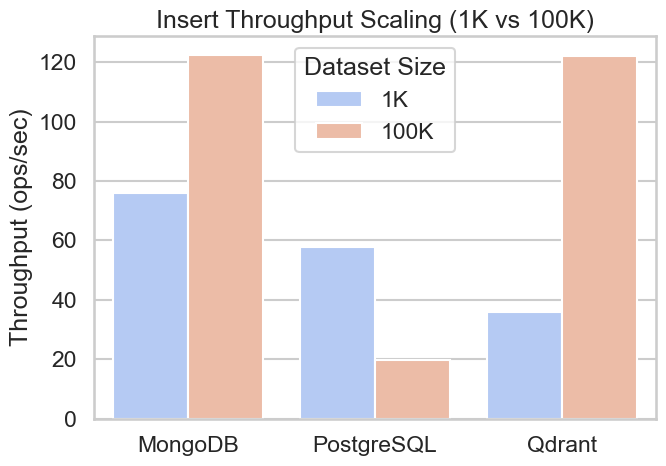

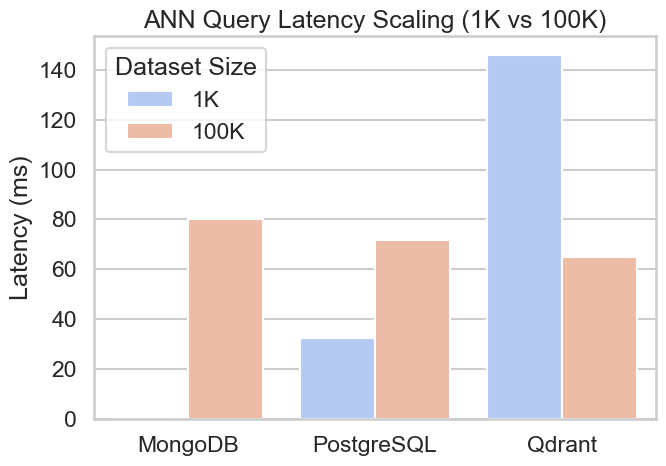

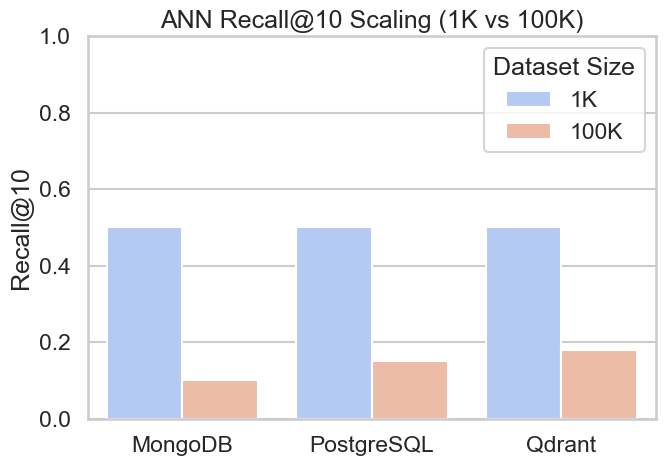

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Data Preparation ===
data = [
    # 1K dataset
    ["MongoDB", "1K", 76.11, 1.89, 529.14, 0.11, 8845.01, 0.50],
    ["PostgreSQL", "1K", 57.94, 21.05, 47.50, 32.54, 30.73, 0.50],
    ["Qdrant", "1K", 35.91, 72.43, 13.81, 146.26, 6.84, 0.50],
    # 100K dataset
    ["MongoDB", "100K", 122.59, None, None, 80.00, 12.50, 0.10],
    ["PostgreSQL", "100K", 19.55, None, None, 71.62, 13.96, 0.15],
    ["Qdrant", "100K", 122.07, None, None, 64.71, 15.45, 0.18],
]

df = pd.DataFrame(data, columns=[
    "Database", "Dataset", "Insert Throughput", "Exact Latency", "Exact Throughput",
    "ANN Latency", "ANN Throughput", "ANN Recall@10"
])

sns.set(style="whitegrid", context="talk")
palette = {"MongoDB": "#4c72b0", "PostgreSQL": "#55a868", "Qdrant": "#c44e52"}

# === Insert Performance Scaling ===
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="Database", y="Insert Throughput", hue="Dataset", palette="coolwarm")
plt.title("Insert Throughput Scaling (1K vs 100K)")
plt.ylabel("Throughput (ops/sec)")
plt.xlabel("")
plt.legend(title="Dataset Size")
plt.tight_layout()
plt.show()

# === ANN Query Latency Scaling ===
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="Database", y="ANN Latency", hue="Dataset", palette="coolwarm")
plt.title("ANN Query Latency Scaling (1K vs 100K)")
plt.ylabel("Latency (ms)")
plt.xlabel("")
plt.legend(title="Dataset Size")
plt.tight_layout()
plt.show()

# === ANN Recall Scaling ===
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="Database", y="ANN Recall@10", hue="Dataset", palette="coolwarm")
plt.title("ANN Recall@10 Scaling (1K vs 100K)")
plt.ylabel("Recall@10")
plt.xlabel("")
plt.ylim(0,1)
plt.legend(title="Dataset Size")
plt.tight_layout()
plt.show()


C:\Users\erict\AppData\Local\Temp\ipykernel_27076\2660216504.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Dataset Size"] = df["Dataset"].replace({"1K": 1_000, "100K": 100_000})


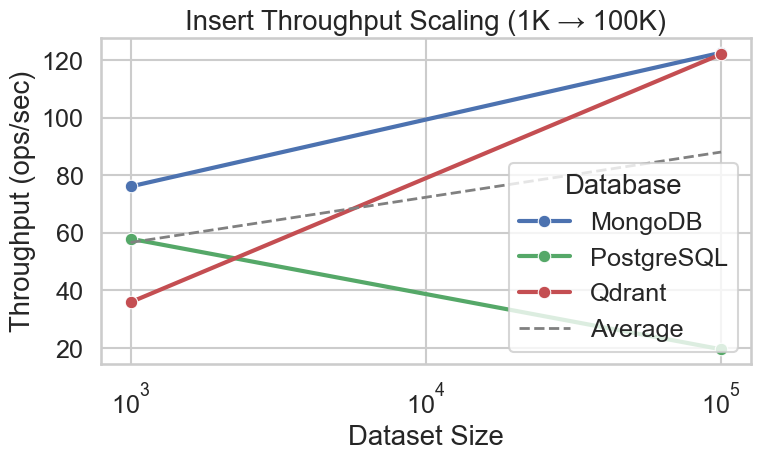

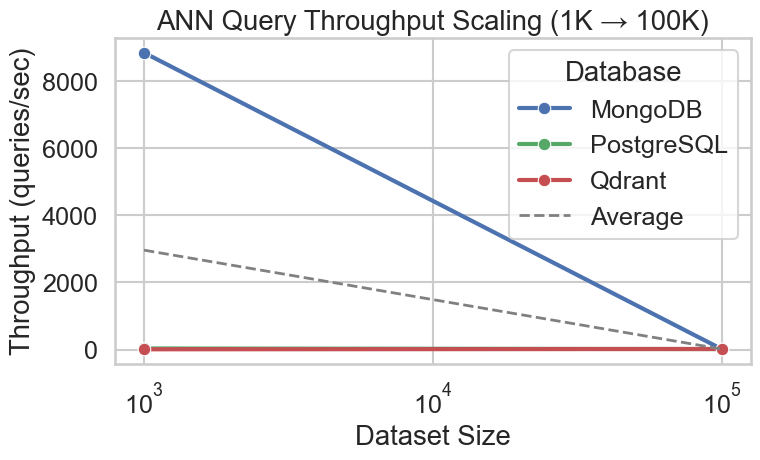

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Data Preparation ===
data = [
    ["MongoDB", "1K", 76.11, 8845.01],
    ["PostgreSQL", "1K", 57.94, 30.73],
    ["Qdrant", "1K", 35.91, 6.84],
    ["MongoDB", "100K", 122.59, 12.50],
    ["PostgreSQL", "100K", 19.55, 13.96],
    ["Qdrant", "100K", 122.07, 15.45],
]

df = pd.DataFrame(data, columns=["Database", "Dataset", "Insert Throughput", "ANN Throughput"])

# Convert dataset size to numeric for proper line plotting
df["Dataset Size"] = df["Dataset"].replace({"1K": 1_000, "100K": 100_000})

# === Compute average throughput per dataset ===
avg_insert = df.groupby("Dataset Size")["Insert Throughput"].mean()
avg_ann = df.groupby("Dataset Size")["ANN Throughput"].mean()

sns.set(style="whitegrid", context="talk", font_scale=1.1)
palette = {"MongoDB": "#4c72b0", "PostgreSQL": "#55a868", "Qdrant": "#c44e52"}

# === Plot: Insert Throughput Scaling ===
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="Dataset Size", y="Insert Throughput", hue="Database",
             marker="o", linewidth=3, palette=palette)
plt.plot(avg_insert.index, avg_insert.values, color="gray", linestyle="--", linewidth=2, label="Average")
plt.xscale("log")
plt.title("Insert Throughput Scaling (1K → 100K)")
plt.ylabel("Throughput (ops/sec)")
plt.xlabel("Dataset Size")
plt.legend(title="Database", loc="best")
plt.tight_layout()
plt.show()

# === Plot: ANN Query Throughput Scaling ===
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="Dataset Size", y="ANN Throughput", hue="Database",
             marker="o", linewidth=3, palette=palette)
plt.plot(avg_ann.index, avg_ann.values, color="gray", linestyle="--", linewidth=2, label="Average")
plt.xscale("log")
plt.title("ANN Query Throughput Scaling (1K → 100K)")
plt.ylabel("Throughput (queries/sec)")
plt.xlabel("Dataset Size")
plt.legend(title="Database", loc="best")
plt.tight_layout()
plt.show()


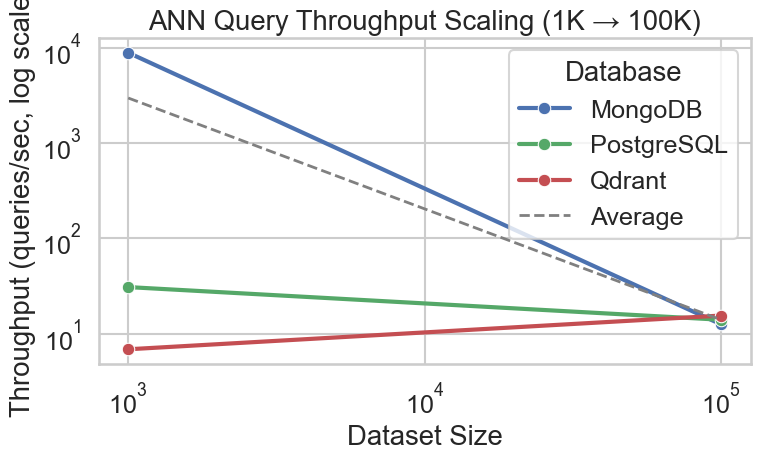

In [5]:
# === Improved ANN Query Throughput Scaling ===
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df, x="Dataset Size", y="ANN Throughput",
    hue="Database", marker="o", linewidth=3, palette=palette
)
plt.plot(avg_ann.index, avg_ann.values, color="gray", linestyle="--", linewidth=2, label="Average")

# Apply logarithmic scale to better show both high and low values
plt.xscale("log")
plt.yscale("log")

plt.title("ANN Query Throughput Scaling (1K → 100K)")
plt.ylabel("Throughput (queries/sec, log scale)")
plt.xlabel("Dataset Size")
plt.legend(title="Database", loc="best")
plt.tight_layout()
plt.show()
